# Import Libraries and Define Tickers

We begin by importing necessary libraries and specifying the two tickers: XOM and GDX.

In [ ]:
!pip install yfinance

In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

tickers = ['XOM', 'GDX']

# Download and Extract Close Prices

We download the 'Close' prices using yfinance and structure the DataFrame for analysis.

In [50]:
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")
close_prices = data.loc[:, ('Close', ['XOM', 'GDX'])]
close_prices.columns = ['XOM', 'GDX']
close_prices.dropna(inplace=True)
close_prices.head()

[*********************100%***********************]  2 of 2 completed
<ipython-input-50-59fac172266c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices.dropna(inplace=True)


,XOM,GDX
Date,,
2023-01-03,97.812378,28.842234
2023-01-04,98.097076,30.067492
2023-01-05,100.291908,29.804935
2023-01-06,101.504105,30.689848
2023-01-09,99.612335,30.398119


# Plot Prices

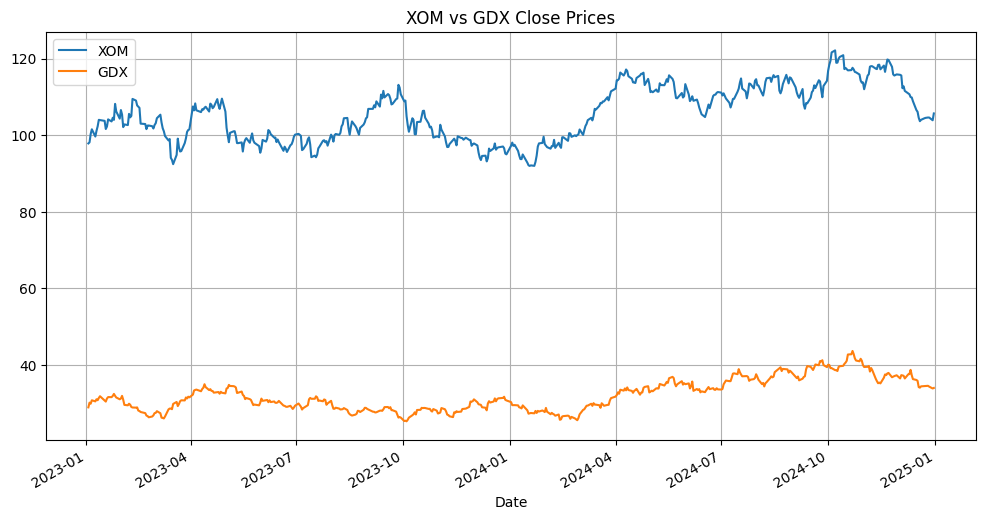

In [51]:
close_prices.plot(figsize=(12, 6))
plt.title('XOM vs GDX Close Prices')
plt.grid(True)
plt.show()

# Cointegration Test

We test for cointegration using the Engle-Granger method. A p-value < 0.05 indicates statistical cointegration.

In [52]:
score, pvalue, _ = coint(close_prices['XOM'], close_prices['GDX'])
print(f"Cointegration p-value: {pvalue:.4f}")


Cointegration p-value: 0.0251


# Calculate Spread and Rolling Z-Score

We construct the spread between XOM and GDX and normalize it using a rolling z-score.

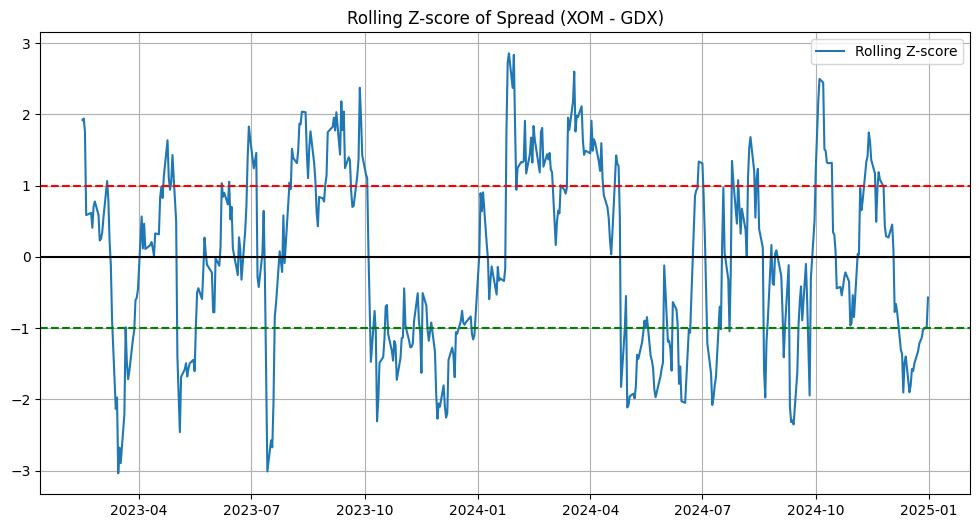

In [58]:
import statsmodels.api as sm
# Regress XOM on GDX to estimate hedge ratio
X = sm.add_constant(close_prices['GDX'])
model = sm.OLS(close_prices['XOM'], X).fit()
hedge_ratio = model.params['GDX']

# Then define spread using hedge ratio
spread = close_prices['XOM'] - hedge_ratio * close_prices['GDX']


rolling_mean = spread.rolling(window=30).mean()
rolling_std = spread.rolling(window=30).std()
zscore = (spread - rolling_mean) / rolling_std

plt.figure(figsize=(12, 6))
plt.plot(zscore, label='Rolling Z-score')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(0, color='black')
plt.legend()
plt.title('Rolling Z-score of Spread (XOM - GDX)')
plt.grid(True)
plt.show()

# Generate Trading Signals

Trading logic: short when z > 1, long when z < -1, and exit when z returns to near 0.

We now enter trades only when the z-score exceeds ±1.5, reducing noise. We exit when the spread reverts within ±0.5.

In [61]:
signals = pd.Series(index=zscore.index, dtype='float64')
signals[zscore > 1.5] = -1
signals[zscore < -1.5] = 1
signals[(zscore >= -0.5) & (zscore <= 0.5)] = 0
signals = signals.ffill().fillna(0)

# Backtest Strategy with Transaction Costs

We simulate PnL using the trading signals and a fixed cost per trade. Performance is evaluated via cumulative return and Sharpe ratio.

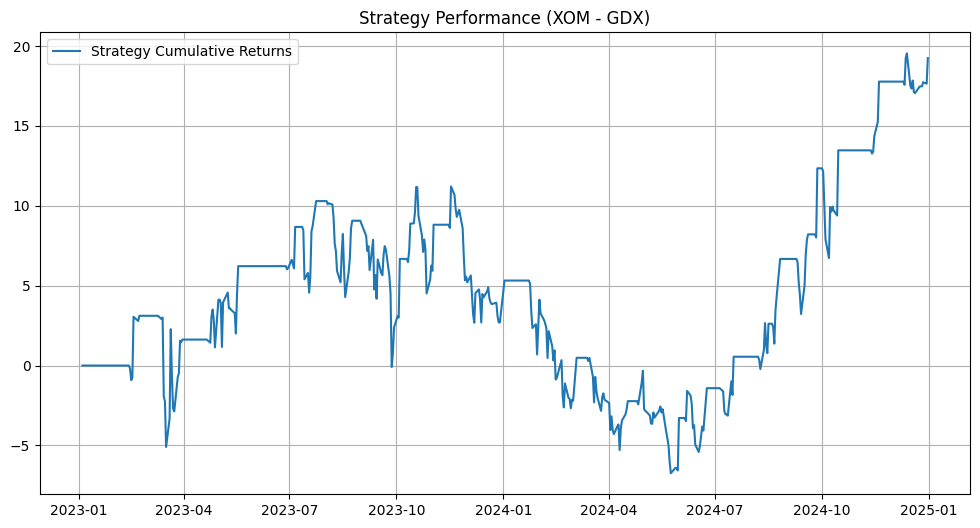

Sharpe Ratio: 0.57


In [62]:
spread_returns = spread.diff()
strategy_returns = signals.shift(1) * spread_returns

cost_per_trade = 0.2
trade_flags = signals.diff().abs() > 0
strategy_returns[trade_flags] -= cost_per_trade

cumulative_returns = strategy_returns.cumsum()
sharpe = strategy_returns.mean() / strategy_returns.std() * (252**0.5)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
plt.title('Strategy Performance (XOM - GDX)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Sharpe Ratio: {sharpe:.2f}")